# Plate

In [1]:
import numpy as np
from hedgehog.plate import *

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%aimport hedgehog.plate
%autoreload 1

### The System

In [2]:
'''
w = [[w1], [w2], [w3], [w4], [w5]]
'''

def w_1_prime(eta, w):
    w2 = w[1][0]
    return w2

def w_2_prime(eta, w):
    w3 = w[2][0]
    return w3

def w_3_prime(eta, w):
    w1 = w[0][0]
    w3 = w[2][0]
    ans = -0.5 * w1 * w3
    return ans

def w_4_prime(eta, w):
    w5 = w[4][0]
    return w5

def w_5_prime(eta, w):
    w1 = w[0][0]
    w5 = w[4][0]
    y = -Pr/2 * w1 * w5
    return y

### Guessing Initial values
#### Just $F$

In [3]:
def get_w2_init(tol=10e-8, isVerbose=False):
    # boundary value for w2
    beta = 1

    # guesses to straddle the root
    a = 0
    b = 1

    # tolerance in the boundary value
    err = tol * 10

    # how much do we want to integrate
    inf = 15
    t0 = 0.0
    tf = inf

    # system
    system = np.array([[w_1_prime], [w_2_prime], [w_3_prime]])

    # continue bisecting while err > tolerance
    while err > tol:

        # boundary value with initial condition as a
        w_0 = np.array([[0.0], [0.0], [a]])
        h = 0.1
        w_a, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # boundary valye with initial condition as b
        w_0 = np.array([[0.0], [0.0], [b]])
        h = 0.1
        w_b, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # how far are the boundary values with each initial guess
        diff_a = np.abs(beta - w_a[1][0])
        diff_b = np.abs(beta - w_b[1][0])

        # perform bisection
        # replace worse guess with the middle point
        c = (a+b) / 2
        if diff_a > diff_b:
            a = c
            err = diff_b
        else:
            b = c
            err = diff_a
    
    if isVerbose:
        print(a, b)
        print(w_a[1][0], w_b[1][0])

    w_2_init = (a + b) / 2
    if isVerbose:
        print(w_2_init)
    
    return w_2_init

#### Both $F$ and $G$

In [4]:
def get_w4_init(w2_init, Pr, tol=10e-8, isVerbose=False):
    # boundary value for w4'
    beta = 0

    # guesses to straddle the root
    a = -2
    b = 4

    err = tol * 10

    # how much do we want to integrate
    inf = 15
    t0 = 0.0
    tf = inf
    h = 0.1

    # system
    system = np.array([[w_1_prime], [w_2_prime], [w_3_prime], [w_4_prime], [w_5_prime]])


    # continue bisecting while err > tolerance
    while err > tol:

        # boundary value with initial condition as a
        w_0 = np.array([[0.0], [0.0], [w2_init], [1.0], [a]])
        w_a, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # boundary valye with initial condition as b
        w_0 = np.array([[0.0], [0.0], [w2_init], [1.0], [b]])
        w_b, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # how far are the boundary values with each initial guess
        diff_a = np.abs(beta - w_a[3][0])
        diff_b = np.abs(beta - w_b[3][0])

        # perform bisection
        # replace worse guess with the middle point
        c = (a+b) / 2
        if diff_a > diff_b:
            a = c
            err = diff_b
        else:
            b = c
            err = diff_a

    w_4_init = (a+b) / 2
    
    if isVerbose:
        print(a, b)
        print(w_a[1][0], w_b[1][0])
        print(w_4_init)
    
    return w_4_init

### Solving system for different $Pr$

In [5]:
def solve_system(Pr, h=0.1, tol=10e-9, inf=15):
    t0 = 0
    tf = inf


    system = np.array([[w_1_prime], [w_2_prime], [w_3_prime], [w_4_prime], [w_5_prime]])
    w_2_init = get_w2_init(tol)
    w_4_init = get_w4_init(w_2_init, Pr, tol)
    w_0 = np.array([[0.0], [0.0], [w_2_init], [1.0], [w_4_init]])

    w_final, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)
    
    return W, T

In [7]:
Pr = 5
W, T = solve_system(Pr=5, h=0.1, tol=10e-9, inf=15)

v = []
u = []
G = []
eta = []

for idx, w in enumerate(W):
    F_prime = w[1][0]
    F = w[0][0]
    t = T[idx]
    v_curr = 0.5 * (t * F_prime - F)
    
    u.append(F_prime)
    eta.append(t)
    v.append(v_curr)
    G.append(w[3][0])

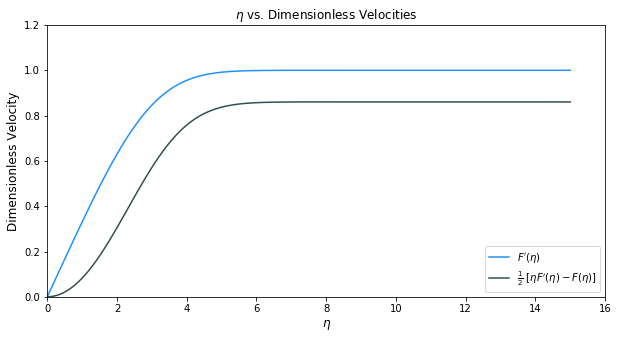

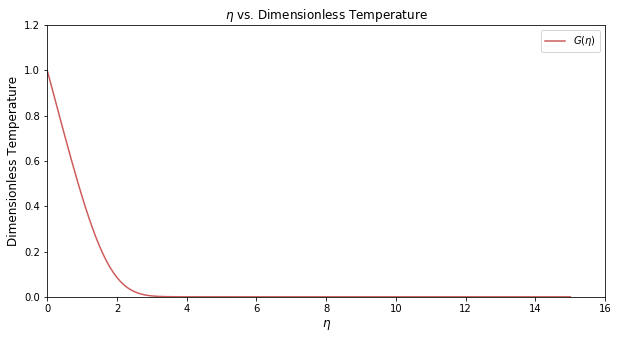

In [8]:
plt.figure(figsize=(10,5))
plt.title(r"$\eta$ vs. Dimensionless Velocities", fontsize=12)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel("Dimensionless Velocity", fontsize=12)
plt.xlim(0, 16)
plt.ylim(0, 1.2)
plt.plot(eta, u, color='dodgerblue', label=r"$F^{\prime}(\eta)$")
plt.plot(eta, v, color='darkslategrey', label=r"$\frac{1}{2}\ [ \eta F^{\prime}(\eta) - F(\eta)]$")
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,5))
plt.title(r"$\eta$ vs. Dimensionless Temperature", fontsize=12)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel("Dimensionless Temperature", fontsize=12)
plt.xlim(0, 16)
plt.ylim(0, 1.2)
plt.plot(eta, G, color='indianred', label=r'$G(\eta)$')
plt.legend()
plt.show()

### Estimating $\eta_{(\ )}$

In [12]:
F_prime = []
eta = []
for idx, w in enumerate(W):
    if w[1][0] >= 0.97 and w[1][0] <= 0.99:
        eta.append(T[idx])
        F_prime.append(w[1][0])
    
eta_m = lagrange_poly(F_prime, eta, 0.98)
print(eta_m)

4.514437636263734


In [13]:
G = []
eta = []
for idx, w in enumerate(W):
    if w[3][0] >= 0.01 and w[3][0] <= 0.03:
        eta.append(T[idx])
        G.append(w[3][0])

eta_t = lagrange_poly(G, eta, 0.02)
print(eta_t)

2.53969596957158
